In [1]:
!pip install torch torchvision torchaudio
!pip install datasets transformers
!pip install g2p_en praatio librosa

In [13]:
import os
from os.path import exists, join, expanduser

os.chdir(expanduser("~"))
charsiu_dir = 'charsiu'
if exists(charsiu_dir):
  !rm -rf /root/charsiu
if not exists(charsiu_dir):
  ! git clone -b development https://github.com/lingjzhu/$charsiu_dir
  ! cd charsiu && git checkout && cd -
  
os.chdir(charsiu_dir)    

Cloning into 'charsiu'...
remote: Enumerating objects: 151, done.
remote: Counting objects: 100% (151/151), done.
remote: Compressing objects: 100% (120/120), done.
remote: Total 151 (delta 53), reused 107 (delta 27), pack-reused 0
Receiving objects: 100% (151/151), 63.20 KiB | 9.03 MiB/s, done.
Resolving deltas: 100% (53/53), done.
Your branch is up to date with 'origin/development'.
/root


In [3]:
import sys
import torch
from datasets import load_dataset
import matplotlib.pyplot as plt

sys.path.insert(0,'src')
from models import Wav2Vec2ForAttentionAlignment
from utils import get_phones, get_phone_ids,audio_preprocess,seq2duration,mapping_id2phone


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Package cmudict is already up-to-date!


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
# load model
model = Wav2Vec2ForAttentionAlignment.from_pretrained('charsiu/en_w2v2_fs_10ms').to(device).eval()

/usr/local/lib/python3.7/dist-packages/transformers/configuration_utils.py:337: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "


In [6]:
# download timit
timit = load_dataset('timit_asr')

Reusing dataset timit_asr (/root/.cache/huggingface/datasets/timit_asr/clean/2.0.1/bce749dca50ede2d9692e53bf7eede501996e25b8aa318280ec9041a9f4c3057)


  0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
sample = timit['train'][0]
phones = get_phones(sample['text'])
print('Text transcription:%s'%(sample['text']))
print('Phone transcription: %s'%phones)

Text transcription:Would such an act of refusal be useful?
Phone transcription: ['W', 'UH', 'D', ' ', 'S', 'AH', 'CH', ' ', 'AE', 'N', ' ', 'AE', 'K', 'T', ' ', 'AH', 'V', ' ', 'R', 'AH', 'F', 'Y', 'UW', 'Z', 'AH', 'L', ' ', 'B', 'IY', ' ', 'Y', 'UW', 'S', 'F', 'AH', 'L', ' ', '?']


In [8]:
audio = audio_preprocess(sample['file'])
phone_ids = get_phone_ids(phones)
batch = {'input_values':torch.tensor(audio).float().unsqueeze(0).to(device),
         'attention_mask': torch.ones(1,len(audio)),
         'labels': torch.tensor(phone_ids).unsqueeze(0).long().to(device),
         'labels_attention_mask':torch.ones(1,len(phone_ids)).to(device),
         'text_len':torch.tensor([len(phone_ids)]).to(device)
        }

with torch.no_grad():
  out = model(**batch)
att = torch.softmax(out.logits,dim=-1),

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


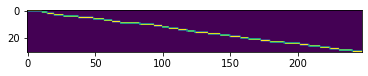

In [9]:
plt.imshow(att[0].squeeze().cpu().detach().transpose(1,0).numpy())

In [10]:
preds = torch.argmax(att[0],dim=-1).cpu().detach().squeeze().numpy()
pred_phones = [mapping_id2phone[phone_ids[i]] for i in preds]
print(seq2duration(pred_phones,resolution=0.01))
print('\\n Ground Truth \\n')
print([(s/16000,e/16000,p) for s,e,p in zip(sample['phonetic_detail']['start'],sample['phonetic_detail']['stop'],sample['phonetic_detail']['utterance'])])

[(0.0, 0.11, '[SIL]'), (0.11, 0.15, 'W'), (0.15, 0.2, 'UH'), (0.2, 0.27, 'D'), (0.27, 0.38, 'S'), (0.38, 0.49, 'AH'), (0.49, 0.57, 'CH'), (0.57, 0.63, 'AE'), (0.63, 0.69, 'N'), (0.69, 0.83, 'AE'), (0.83, 0.94, 'K'), (0.94, 1.0, 'T'), (1.0, 1.05, 'AH'), (1.05, 1.12, 'V'), (1.12, 1.19, 'R'), (1.19, 1.24, 'AH'), (1.24, 1.34, 'F'), (1.34, 1.43, 'Y'), (1.43, 1.5, 'UW'), (1.5, 1.58, 'Z'), (1.58, 1.64, 'AH'), (1.64, 1.73, 'L'), (1.73, 1.8, 'B'), (1.8, 1.91, 'IY'), (1.91, 2.02, 'Y'), (2.02, 2.09, 'UW'), (2.09, 2.17, 'S'), (2.17, 2.24, 'F'), (2.24, 2.31, 'AH'), (2.31, 2.41, 'L'), (2.41, 2.48, '[SIL]')]
\n Ground Truth \n
[(0.0, 0.1225, 'h#'), (0.1225, 0.154125, 'w'), (0.154125, 0.2175, 'ix'), (0.2175, 0.25, 'dcl'), (0.25, 0.3725, 's'), (0.3725, 0.4675, 'ah'), (0.4675, 0.4925, 'tcl'), (0.4925, 0.5875, 'ch'), (0.5875, 0.6225, 'ix'), (0.6225, 0.6675, 'n'), (0.6675, 0.8425, 'ae'), (0.8425, 0.98, 'kcl'), (0.98, 0.9925, 't'), (0.9925, 1.0575, 'ix'), (1.0575, 1.1435625, 'v'), (1.1435625, 1.180125, 'r'